<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use Core ML model to predict Boston house prices</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/spark/customer-satisfaction-prediction/images/users_banner_2-03.png" width="600" alt="Icon"> </th>
   </tr>
</table>

This notebook contains the steps and code to work with the <a href="https://pypi.python.org/pypi/watson-machine-learning-client" target="_blank" rel="noopener no referrer">watson-machine-learning-client</a> library available in PyPI repository. This notebook introduces commands for getting data and for basic data exploration, pipeline creation, model training and evaluation, model persistance to the Watson Machine Learning (WML) repository, and model deployment.

Some familiarity with Python is helpful. This notebook uses Python 3.5, scikit-learn and the watson-machine-learning-client package.

You will use the sample data set **sklearn.datasets.load_boston**, which is available in scikit-learn, to predict house prices.

## Learning goals

In this notebook, you will learn how to:

-  Load a sample data set from ``scikit-learn``
-  Explore data
-  Prepare data for training and evaluation
-  Create an scikit-learn machine learning pipeline
-  Train and evaluate a model
-  Store a model in the Watson Machine Learning (WML) repository
-  Deploy a model as Core ML


## Contents

1.	[Set up the environment](#setup)
2.	[Load and explore data](#load)
3.	[Create the scikit-learn model](#model)
4.	[Save the model](#persistence)
5.	[Deploy and score data in the IBM Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))

- Configure your local python environment:
  + python 3.5
  + scikit-learn 0.19.1
  + watson-machine-learning-client

**Tip**: Run the cell below to install libraries from <a href="https://pypi.python.org/pypi" target="_blank" rel="noopener no referrer">PyPI</a>.

In [1]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [2]:
!pip install -q --upgrade watson-machine-learning-client

<a id="load"></a>
## 2. Load and explore data

In this section you will load the data from scikit-learn sample data sets and then perform a basic exploration. The data set can be found <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/housing/" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
import sklearn
from sklearn import datasets
import pandas as pd

boston_data = datasets.load_boston()

The sample data set contains boston house-prices.

In [4]:
print(boston_data.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


**Tip:** Run `print(boston_data.DESCR)` to view a detailed description of the data set.

Create a pandas DataFrame and display some descriptive statistics.

In [5]:
boston_pd = pd.DataFrame(boston_data.data)
boston_pd.columns = boston_data.feature_names
boston_pd['PRICE'] = boston_data.target

print(boston_pd.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


In [6]:
print(boston_pd.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.647423   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

<a id="model"></a>
## 3. Create a scikit-learn model

In this section you learn how to:
- [3.1 Prepare the data](#prep)
- [3.2 Create the scikit-learn pipeline](#pipe)
- [3.3 Train a model](#train)

### 3.1 Prepare the data<a id="prep"></a>

In this subsection you will split your data into: 
- Train data set
- Test data set

In [7]:
from sklearn.model_selection import train_test_split

X = boston_pd.drop('PRICE', axis = 1)
Y = boston_pd['PRICE']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

print('Number of training records: ' + str(X_train.shape[0]))
print('Number of training records: ' + str(X_test.shape[0]))

Number of training records: 339
Number of training records: 167


Your data has been successfully split into two data sets: 

-  The train data set, which is the largest group, is used for training
-  The test data set will be used for model evaluation and is used to test the assumptions of the model

### 3.2 Create the scikit-learn machine learning pipeline<a id="pipe"></a>

In this section you will create a scikit-learn machine learning pipeline.

First, import the scikit-learn machine learning packages that are needed in the subsequent steps.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Standardize the features by removing the mean and by scaling to unit variance.

In [9]:
scaler = preprocessing.StandardScaler()

Next, define the regressor you want to use. The following example uses the Linear Regression algorithm.

In [10]:
lr = LinearRegression()

Build the pipeline. A pipeline consists of transformer and an estimator.

In [11]:
pipeline = Pipeline([('scaler', scaler), ('lr', lr)])

### 3.3 Train the model<a id="train"></a>

Now, you can use the **pipeline** and **train data** you defined previously to train your SVM model.

In [12]:
model = pipeline.fit(X_train, Y_train)

Check the model quality.

In [13]:
Y_pred = model.predict(X_test)
mse = sklearn.metrics.mean_squared_error(Y_test, Y_pred)

print('MSE: ' + str(mse))

MSE: 28.5413672756


Plot the scatter plot of prices vs. predicted prices.

Text(0.5,1,'Predicted prices vs prices')

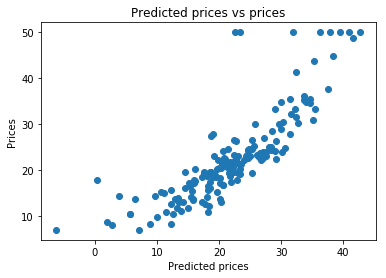

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter (Y_pred, Y_test)

plt.ylabel("Prices")
plt.xlabel("Predicted prices")
plt.title("Predicted prices vs prices")

**Note:** You can tune your model to achieve better accuracy. To keep this example simple, the tuning section is omitted.

<a id="persistence"></a>
## 4. Work with the WML repository

In this section you will learn how to use the common Python client to manage your model in the WML repository.

- [4.1 Work with your WML instance](#work)
- [4.2 Save the model to the WML repository](#save)

**Tip**: You can find more information about the watson-machine-learning-client [here](https://wml-api-pyclient.mybluemix.net).

### 4.1 Work with your WML instance<a id="work"></a>

First, you must import the client libraries.

In [15]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

2018-06-07 17:32:13,830 - root - WARNING - Keras version 2.1.4 detected. Last version known to be fully compatible of Keras is 2.1.3 .


Authenticate to the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the [Service Credentials](https://console.bluemix.net/docs/services/service_credentials.html#service_credentials) tab of the service instance that you created on IBM Cloud. <BR>If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.


In [16]:
wml_credentials = {
  "username": "***",
  "password": "***",
  "instance_id": "***",
  "url": "https://ibm-watson-ml.mybluemix.net"
}

#### Create the API client. 

In [17]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.2 Save the model to the WML repository<a id="save"></a>

Define the model name, author name and email.

In [18]:
published_model = client.repository.store_model(model=model, meta_props={'name':'Boston house price prediction'}, training_data=X_train, training_target=Y_train)

In [19]:
model_uid = client.repository.get_model_uid(published_model)

#### Get information about all of the models in the WML repository.

In [20]:
models_details = client.repository.list_models()

------------------------------------  -----------------------------  ------------------------  -----------------
GUID                                  NAME                           CREATED                   FRAMEWORK
b45681a0-3cb5-45bd-ab81-29fa414eb1c6  Boston house price prediction  2018-06-07T17:29:38.361Z  scikit-learn-0.19
------------------------------------  -----------------------------  ------------------------  -----------------


<a id="scoring"></a>
## 5. Deploy model as Core ML

In this section you will learn how to use the WML client to create a **virtual** deployment with `Core ML` format. You will also learn how to use `download_url` to download a Core ML model for your X Code project.

- [5.1 Create the virtual deployment](#create)
- [5.2 Download deployment](#getdeploy)

### 5.1 Create the virtual deployment for the model<a id="create"></a>

In [21]:
deployment_details = client.deployments.create(model_uid, "Virtual deployment of Boston model", deployment_type='virtual')



#######################################################################################

Synchronous deployment creation for uid: 'b45681a0-3cb5-45bd-ab81-29fa414eb1c6' started

#######################################################################################


DEPLOY_IN_PROGRESS.....
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='fbe6361f-fc22-4148-af95-49bf419a59ca'
------------------------------------------------------------------------------------------------




Once you see DEPLOY_SUCCESS, you can define and print the download endpoint. You can use this endpoint to download the Core ML model.

In [22]:
download_endpoint = client.deployments.get_download_url(deployment_details)

print(download_endpoint)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/b45681a0-3cb5-45bd-ab81-29fa414eb1c6/versions/b16ef974-65c7-4bd9-949c-a4f2d4a5e744/content?format=coreML


### 5.2 Get the `Core ML` file from the deployment<a id="getdeploy"></a>

In [23]:
client.deployments.list()

------------------------------------  ----------------------------------  -------  --------------  ------------------------  -----------------
GUID                                  NAME                                TYPE     STATE           CREATED                   FRAMEWORK
fbe6361f-fc22-4148-af95-49bf419a59ca  Virtual deployment of Boston model  virtual  DEPLOY_SUCCESS  2018-06-07T17:30:00.234Z  scikit-learn-0.19
------------------------------------  ----------------------------------  -------  --------------  ------------------------  -----------------


#### Download the virtual deployment content: Core ML model.

In [24]:
deployment_uid = client.deployments.get_uid(deployment_details)

deployment_content = client.deployments.download(deployment_uid)



-------------------------------------------------------
Successfully downloaded deployment file: mlmodel.tar.gz
-------------------------------------------------------




Use the code in the cell below to create the download link.

In [25]:
from watson_machine_learning_client.utils import create_download_link

create_download_link(deployment_content)

**Note:** You can use XCode to preview the model's metadata (after unzipping). 

### 5.3 Test `Core ML` model<a id="score"></a>

Use the following method to run a test against the downloaded Core ML model.

In [26]:
!pip -q install coremltools

Use the ``coremltools`` to load the model and check some basic metadata.

First, extract the model.

In [27]:
from watson_machine_learning_client.utils import extract_mlmodel_from_archive

extracted_model_path = extract_mlmodel_from_archive('mlmodel.tar.gz', model_uid)

Load the model and check the description.

In [28]:
import coremltools

loaded_model = coremltools.models.MLModel(extracted_model_path)
print(loaded_model.short_description)

Boston house price prediction


The model looks good and can be used on your iPhone application now.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use scikit-learn to create Core ML machine learning model.

If you are interested in sample swift application (for iOS) please go [here](https://github.com/pmservice/go-digits) 

Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Lukasz Cmielowski** is a Lead Data Scientist at IBM developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>